In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math 
import random
from sklearn.model_selection import train_test_split 

import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms, align
import nglview as nv
import pandas as pd

## Part 1: prepare MD data
#### 1.1. show some information

In [4]:
sys_name = 'AlanineDipeptide'

# name of PDB file
pdb_filename = "MD_samplers/AlanineDipeptideOpenMM/vacuum.pdb"
# name of DCD file
output_path = 'MD_samplers/allegro-data/working_dir/Langevin_working_dir' 
#output_path = './allegro-data/working_dir/Langevin_working_dir-test3-plumed/' 
traj_dcd_filename = '%s/traj.dcd' % output_path

# load the reference configuration from the PDB file
ref = mda.Universe(pdb_filename) 

atoms_info = pd.DataFrame(
    np.array([ref.atoms.ids, ref.atoms.names, ref.atoms.types, ref.atoms.masses, ref.atoms.resids, ref.atoms.resnames]).T, 
    columns=['id', 'name', 'type', 'mass', 'resid', 'resname']
)

# print information of trajectory
print ('\nMD system:\n\
\tno. of atoms: {}\n\
\tno. of residues: {}\n'.format(ref.trajectory.n_atoms, ref.residues.n_residues)
      )
print ('Detailed atom information:\n', atoms_info)

print ('\nSummary:\n', atoms_info['type'].value_counts().rename_axis('type').reset_index(name='counts'))


MD system:
	no. of atoms: 22
	no. of residues: 3

Detailed atom information:
     id  name type    mass resid resname
0    1  1HH3    H   1.008     1     ACE
1    2   CH3    C  12.011     1     ACE
2    3  2HH3    H   1.008     1     ACE
3    4  3HH3    H   1.008     1     ACE
4    5     C    C  12.011     1     ACE
5    6     O    O  15.999     1     ACE
6    7     N    N  14.007     2     ALA
7    8     H    H   1.008     2     ALA
8    9    CA    C  12.011     2     ALA
9   10    HA    H   1.008     2     ALA
10  11    CB    C  12.011     2     ALA
11  12   1HB    H   1.008     2     ALA
12  13   2HB    H   1.008     2     ALA
13  14   3HB    H   1.008     2     ALA
14  15     C    C  12.011     2     ALA
15  16     O    O  15.999     2     ALA
16  17     N    N  14.007     3     NME
17  18     H    H   1.008     3     NME
18  19   CH3    C  12.011     3     NME
19  20  1HH3    H   1.008     3     NME
20  21  2HH3    H   1.008     3     NME
21  22  3HH3    H   1.008     3     NME



/home/wei/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


#### 1.2 load trajectory, and align with respect to refenrence

In [39]:
# define a class for aligning trajectory
class Align(object):
    def __init__(self, ref_pos, align_atom_indices):
        self.atom_indices = align_atom_indices
        self.ref_x = torch.from_numpy(ref_pos[align_atom_indices]).double()        
        # shift reference state 
        ref_c = torch.mean(self.ref_x, 0) 
        self.ref_x = self.ref_x - ref_c
        self.num_atoms = len(align_atom_indices) * 3
        
    def dist_to_ref(self, traj):
        return torch.linalg.norm(torch.sub(traj[:,self.atom_indices,:], self.ref_x), dim=(1,2)).numpy()     
            
    def __call__(self, traj):    
        traj_selected_atoms = traj[:, self.atom_indices, :]
        # centers
        x_c = torch.mean(traj_selected_atoms, 1, True)
        # translation
        x_notran = traj_selected_atoms - x_c 
        
        xtmp = x_notran.permute((0,2,1))
        prod = torch.matmul(xtmp, self.ref_x) # dimension: traj_length x 3 x 3
        u, s, vh = torch.linalg.svd(prod)

        diag_mat = torch.diag(torch.ones(3)).double().unsqueeze(0).repeat(traj.size(0), 1, 1)

        sign_vec = torch.sign(torch.linalg.det(torch.matmul(u, vh))).detach()
        diag_mat[:,2,2] = sign_vec

        rotate_mat = torch.bmm(torch.bmm(u, diag_mat), vh)

        return torch.matmul(traj-x_c, rotate_mat)     

# load the trajectory data from DCD file
u = mda.Universe(pdb_filename, traj_dcd_filename)

print ('\n[Task 1/2] load trajectory to numpy array...', end='')
# load trajectory to torch tensor 
trajectory = torch.from_numpy(u.trajectory.timeseries(order='fac')).double()
print ('done.')

# print information of trajectory
print ('\nTrajectory Info:\n\
\tno. of frames in trajectory data: {}\n\
\ttimestep: {:.1f}ps\n\
\ttime length: {:.1f}ps\n\
\tshape of trajectory data array: {}'.format(u.trajectory.n_frames, 
                                  u.trajectory.time, 
                                  u.trajectory.totaltime,
                                  trajectory.shape
                                 )
      )

align_selector = "type C or type O or type N"
selected_ids = u.select_atoms(align_selector).ids

align_functor = Align(ref.atoms.positions, selected_ids-1)

print ('\n[Task 2/2] aligning by atoms:')
print (atoms_info.loc[atoms_info['id'].isin(selected_ids)][['id','name', 'type']])

head_frames = 5
dist_list = align_functor.dist_to_ref(trajectory[:head_frames,:,:])
trajectory = align_functor(trajectory)
dist_list_aligned = align_functor.dist_to_ref(trajectory[:head_frames,:,:])

"""
#One could also use the alignment methods provided in MDAnalysis package 
rmsd_list = []
for idx in range(head_frames):
    rmsd_ret = rms.rmsd(trajectory[idx,selected_ids-1,:], ref_pos[selected_ids-1,:], superposition=False)
    rmsd_list.append(rmsd_ret)

align.AlignTraj(u,  # trajectory to align
                ref,  # reference
                select=align_selector,  # selection of atoms to align
                filename=None,  # file to write the trajectory to
                in_memory=True,
                match_atoms=True,  # whether to match atoms based on mass
               ).run()

print ('\n[Task 1/2] done.')

rmsd_list_aligned = []
for ts in u.trajectory[:head_frames]:
    rmsd_ret = rms.rmsd(u.select_atoms(align_selector).positions, ref.select_atoms(align_selector).positions, superposition=False)
    rmsd_list_aligned.append(rmsd_ret)
"""

print ('\n[Task 2/2] done.')

/home/wei/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "



[Task 1/2] load trajectory to numpy array...done.

Trajectory Info:
	no. of frames in trajectory data: 50000
	timestep: 1.0ps
	time length: 49999.0ps
	shape of trajectory data array: torch.Size([50000, 22, 3])

[Task 2/2] aligning by atoms:
    id name type
1    2  CH3    C
4    5    C    C
5    6    O    O
6    7    N    N
8    9   CA    C
10  11   CB    C
14  15    C    C
15  16    O    O
16  17    N    N
18  19  CH3    C
torch.Size([50000, 22, 3])

[Task 2/2] done.


#### (optional) display information

First 5 distance values before alignment:
	 [20.68378689 22.18273096 24.31330916 23.95234415 23.24669574]

First 5 distance values after alignment:
	 [0.97998441 1.44018644 0.67766133 1.63945315 1.84342085]


NGLWidget(max_frame=49999)

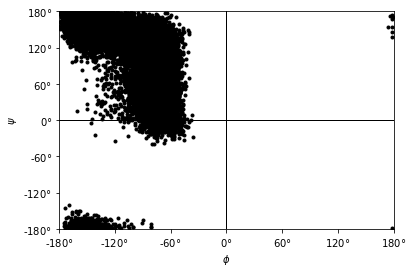

In [35]:
#print RMSD values before and after alignment
print ('First {} distances before alignment:\n\t'.format(head_frames), dist_list)
print ('\nFirst {} distances after alignment:\n\t'.format(head_frames), dist_list_aligned)

#generate Ramachandran plot of two dihedral angles
ax = plt.axes()
r = dihedrals.Ramachandran(u.select_atoms('resid 2')).run()
r.plot(ax, color='black', marker='.') #, ref=True)

# display the trajectory
view = nv.show_mdanalysis(u)
view   

## Part 2: Training

#### define neural network model and training function

In [41]:
#Auto encoders class and functions for training.
def create_seqential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = []
    for i in range(len(layer_dims)-2) :
        layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.append(activation)
    layers.append(torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    
    return torch.nn.Sequential(*layers)
       
class Encoder(torch.nn.Module):
    def __init__(self, align_func, encoder_dims, activation=torch.nn.Tanh(), atom_indices=None):
        """Initialise auto encoder

        :param encoder_dims: list, List of dimensions for encoder, including input/output layers
        """
        super(Encoder, self).__init__()
        self.align_func = align_func
        self.atom_indices = atom_indices
        self.encoder = create_seqential_nn(encoder_dims, activation)

    def forward(self, inp):
        # flatten the data
        if self.atom_indices is None: # use all atoms
            inp = torch.flatten(inp, start_dim=1)            
        else: # use selected atoms
            inp = torch.flatten(inp[:,self.atom_indices,:], start_dim=1)
        encoded = self.encoder(inp)
        return encoded

    def xi(self, x, is_aligned=True):
        """Collective variable defined through the encoder 

        :param x: np.array, position, ndim = 2, shape = (1,1)

        :return: xi: np.array
        """
        if torch.is_tensor(x) == False :
            x = torch.from_numpy(x).float()
        return self.encoder(x).detach().numpy()

# Next, we define the training function 
def train(model, optimizer, traj, weights, train_atom_indices, num_epochs=10, batch_size=32, test_ratio=0.2):
    """Function to train an AE model
    
    :param model: Neural network model built with PyTorch,
    :param loss_function: Function built with PyTorch tensors or built-in PyTorch loss function
    :param optimizer: PyTorch optimizer object
    :param traj: np.array, physical trajectory (in the potential pot), ndim == 2, shape == T // save + 1, pot.dim
    :param weights: np.array, weights of each point of the trajectory when the dynamics is biased, ndim == 1, shape == T // save + 1, 1
    :param num_epochs: int, number of times the training goes through the whole dataset
    :param batch_size: int, number of data points per batch for estimation of the gradient
    :param test_size: float, between 0 and 1, giving the proportion of points used to compute test loss

    :return: model, trained neural net model
    :return: loss_list, list of lists of train losses and test losses; one per batch per epoch
    """
    #--- prepare the data ---
    # split the dataset into a training set (and its associated weights) and a test set
    X_train, X_test, w_train, w_test = train_test_split(traj, weights, test_size=test_ratio)  
    # intialization of the methods to sample with replacement from the data points (needed since weights are present)
    train_sampler = torch.utils.data.WeightedRandomSampler(w_train, len(w_train))
    test_sampler  = torch.utils.data.WeightedRandomSampler(w_test, len(w_test))
    # method to construct data batches and iterate over them
    train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=train_sampler)
    test_loader  = torch.utils.data.DataLoader(dataset=X_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=test_sampler)
    
    loss_func = torch.nn.MSELoss()
    # --- start the training over the required number of epochs ---
    loss_list = []
    print ("\ntraining starts, %d epochs in total." % num_epochs) 
    for epoch in range(num_epochs):
        # Train the model by going through the whole dataset
        model.train()
        train_loss = []
        for iteration, X in enumerate(train_loader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output
            out = model(X)
            # Evaluate loss
            loss = loss_func(out, torch.flatten(X[:,train_atom_indices,:],start_dim=1))
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Store loss
            train_loss.append(loss)
            # Updating parameters
            optimizer.step()
            print (epoch, iteration)
        # Evaluate the test loss on the test dataset
        model.eval()
        with torch.no_grad():
            # Evaluation of test loss
            test_loss = []
            for iteration, X in enumerate(test_loader):
                out = model(X)
                # Evaluate loss
                loss = loss_func(out, torch.flatten(X[:,train_atom_indices,:],start_dim=1))
                # Store loss
                test_loss.append(loss)
            loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])

    print ("training ends.\n") 
    return model, loss_list

#### set training parameters 

In [44]:
def set_seed_all(seed=-1):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

#All the parameters are set in the cell below. 
seed = None 
if seed:
    set_seed_all(seed)
    
#set training parameters
batch_size = 10000
num_epochs = 500
learning_rate = 0.005
optimizer_algo = 'Adam'  # Adam by default, otherwise SGD
#dimensions

train_atom_selector = "type C or type O or type N"
train_atom_ids = u.select_atoms(align_selector).ids 
train_atom_indices = train_atom_ids - 1 # minus one, such that the index starts from 0

#input dimension
input_dim = 3 * len(train_atom_ids)
print ('{} Atoms used in define neural network:\n'.format(len(train_atom_ids)), atoms_info.loc[atoms_info['id'].isin(train_atom_ids)][['id','name', 'type']])

# encoded dimension
k = 1
e_layer_dims = [input_dim, 20, 20, k]
d_layer_dims = [k, 20, 20, input_dim]
print ('\nInput dim: {},\tencoded dim: {}\n'.format(input_dim, k))

activation = torch.nn.Tanh()
encoder = Encoder(align_functor, e_layer_dims, activation, train_atom_indices)
decoder = create_seqential_nn(d_layer_dims, activation)

ae_model = torch.nn.Sequential(encoder, decoder) 

print ('Autoencoder:\n', ae_model)

10 Atoms used in define neural network:
     id name type
1    2  CH3    C
4    5    C    C
5    6    O    O
6    7    N    N
8    9   CA    C
10  11   CB    C
14  15    C    C
15  16    O    O
16  17    N    N
18  19  CH3    C

Input dim: 30,	encoded dim: 1

Autoencoder:
 Sequential(
  (0): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=30, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=30, bias=True)
  )
)


#### start training 

In [142]:
# Define the optimizer
if optimizer_algo == 'Adam':
    optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(ae_model.parameters(), lr=learning_rate)

ae_model, loss_list = train(ae_model, 
                            optimizer, 
                            trajectory, 
                            np.ones(trajectory.shape[0]), 
                            train_atom_indices,
                            batch_size=batch_size, 
                            num_epochs=num_epochs
                            )

#--- Compute average train per epoch ---
loss_evol1 = []
for i in range(len(loss_list)):
    loss_evol1.append([torch.mean(loss_list[i][0]), torch.mean(loss_list[i][1])])
loss_evol1 = np.array(loss_evol1)


training starts, 500 epochs in total.
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
11 0
11 1
11 2
11 3
12 0
12 1
12 2
12 3
13 0
13 1
13 2
13 3
14 0
14 1
14 2
14 3
15 0
15 1
15 2
15 3
16 0
16 1
16 2
16 3
17 0
17 1
17 2
17 3
18 0
18 1
18 2
18 3
19 0
19 1
19 2
19 3


KeyboardInterrupt: 

Plot the results 

In [ ]:
save_fig_to_file = False
start_epoch_index = 1
fig, (ax0, ax1, ax2)  = plt.subplots(1,3, figsize=(12,4)) 
ax0.plot(range(start_epoch_index, num_epochs), loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='o')
ax0.plot(range(1, num_epochs), loss_evol1[start_epoch_index:, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax0.set_title('losses')

if save_fig_to_file :
    fig_filename = 'training_loss_%s.jpg' % pot_name
    fig.savefig(fig_filename)
    print ('training loss plotted to file: %s' % fig_filename)